In [1]:
import pandas as pd
# import cudf
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
import seaborn as sns 
import xgboost
import mlflow
from sklearn.model_selection import train_test_split
# from cuml.model_selection import train_test_split

In [2]:
plot_params = {
    'font.family': 'Ubuntu',
    'font.weight': 'light',
    
    'figure.figsize': (15,5),
    'figure.frameon': False, 
    'figure.titlesize': 'xx-large',
    'figure.titleweight': 'normal',
    
    'axes.titlesize': 'x-large',
    'axes.titlecolor': 'black',
    'axes.titleweight': 'normal',
    'axes.titlelocation': 'center',
    'axes.labelsize': 'x-large',

    'grid.alpha': .25, 
    'legend.frameon':False,
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
}

In [3]:
pylab.rcParams.update(plot_params)
sns.set_palette('mako')

In [4]:
SEED = 1943
np.random.seed(SEED)

In [5]:
os.listdir('data')

['Lyrics-Genre-Test-GroundTruth.csv', 'Lyrics-Genre-Train.csv']

In [6]:
TRAIN_PATH = 'data/Lyrics-Genre-Train.csv'
TEST_PATH = 'data/Lyrics-Genre-Test-GroundTruth.csv'

In [22]:
train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)

In [63]:
X_train, Y_train = train_data['Lyrics'], train_data['Genre']

X_test, Y_test = test_data['Lyrics'], test_data['Genre']

In [64]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size= .15, random_state = SEED, stratify = Y_train)

#### EDA

In [22]:
train_data.shape

(18513, 6)

In [23]:
train_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,forest-enthroned,2007,catamenia,Metal,"I am a night in to the darkness, only soul los...",18096
1,superhero,2010,aaron-smith,Hip-Hop,"Yeah\nSometimes, i just wanna fly away.\nThey ...",22724
2,chicago-now,2007,fall,Metal,Do you work hard?\nDo you work hard?\nYou don'...,24760
3,the-secret,2007,geto-boys,Hip-Hop,You know what? I'm destined to be the last man...,24176
4,be-the-lake,2011,brad-paisley,Country,There ain't nothing that I would rather see\nT...,17260


In [24]:
test_data.shape

(7935, 6)

In [25]:
test_data.head()

,Song,Song year,Artist,Genre,Lyrics,Track_id
0,craftsmanship,2005,buck-65,Hip-Hop,Most folks spend their days daydreaming of fin...,8294
1,come-on-out,2012,the-elwins,Indie,Take your cold hands and put them on my face\n...,21621
2,riot,2013,bullet-for-my-valentine,Metal,Are you ready it's time for war\nWe'll break d...,3301
3,that-s-what-girls-do,2007,dream-street,Pop,You ask me why I change the color of my hair\n...,2773
4,believe-in-a-dollar,2012,cassidy,Hip-Hop,Do you believe in magic in a young girl's hear...,16797


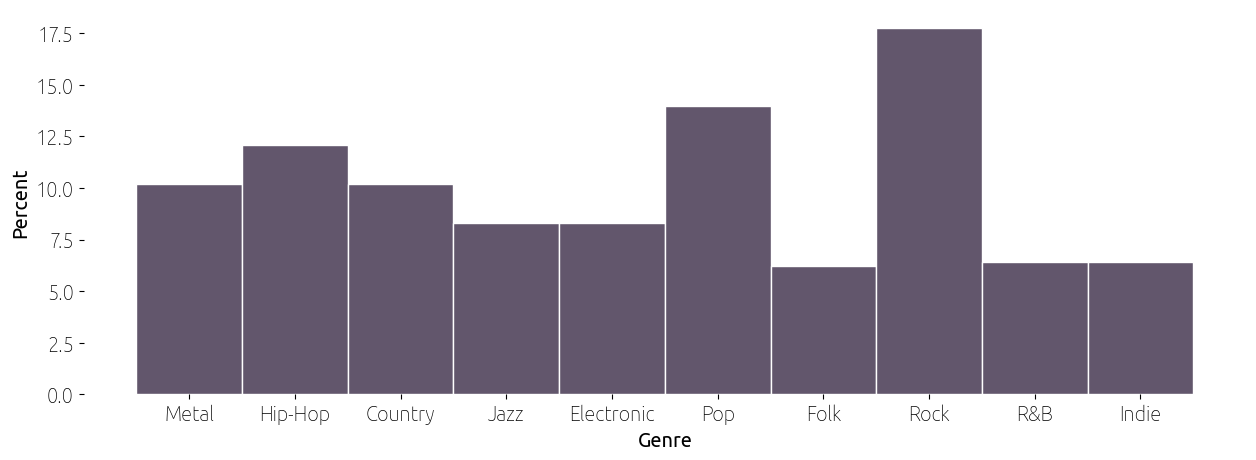

In [26]:
sns.histplot(train_data['Genre'], edgecolor = 'white', stat = 'percent')
plt.box(False)
plt.show()


In [27]:
train_data['Genre'].nunique()

10

There are 10 classes. A somewhat unbalanced dataset. Three classes with less than 5% samples. The majority class being Rock w/ approximately 18% of the entries.

In [28]:
train_data.groupby('Genre')['Lyrics']

Some samples from each group, should be checked.

#### Modeling

In [10]:
# Tracking
mlflow.get_tracking_uri()

'file:///home/mikhailtal/Desktop/hnnaharendt/lyrics-project/mlruns'

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [52]:
# Define metrics
def calculate_metrics(Y_true, Y_pred, log = False, verbose = True):
    ACC = accuracy_score(Y_true, Y_pred)
    F_SCORE = f1_score(Y_true, Y_pred, average = 'micro')
    PRECISION = precision_score(Y_true, Y_pred, average= 'micro')
    RECALL = recall_score(Y_true, Y_pred, average = 'micro')
    # RAS = roc_auc_score(Y_true, Y_pred, multi_class='ovr')
    MCC = matthews_corrcoef(Y_true, Y_pred)
    C_REPORT = classification_report(Y_true, Y_pred)
    
    if verbose:
        print('Metrics:')
        print(f'\t Accuracy \t\t{ACC}')

        print(f'\t F-Score \t\t{F_SCORE}')

        print(f'\t Precision \t\t{PRECISION}')

        print(f'\t Recall \t\t{RECALL}')

        print(f"\t Matthew's cc \t\t{MCC}")

        # print(f'\t ROC-AUC \t\t{RAS}')

        print(f'\n{C_REPORT}')

    ...

In [65]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [66]:
X_train

13453    Oh, the weather outside is frightful,\nBut the...
1858     [Busta Talking]\nBounce, Bounce, Bounce niggas...
14487    I'll be home for Christmas;\nYou can play on m...
2255     Just the other day, I was looking for myself a...
15266    (Gray.)\nGot me seeing crooked, like the scree...
                               ...                        
15917    Sometimes I stop\nTake a look at myself\nAnd r...
4156     At times the women deep inside me\nWanders far...
11903    KANJI LYRICS\nWe back again å ã
ã­ãã¯ã...
15673    There'll always be another tear there'll alway...
1113     Nine to five a.m., gonna party all weekend\nI ...
Name: Lyrics, Length: 15736, dtype: object

In [67]:
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_valid = vectorizer.transform(X_valid)

In [68]:
X_train.shape, X_valid.shape

((15736, 831805), (2777, 831805))

In [69]:
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
Y_valid = encoder.transform(Y_valid)

In [70]:
model = xgboost.XGBClassifier(tree_method = 'gpu_hist')

In [71]:
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [72]:
Y_pred = model.predict(X_valid)

CountVectorizer; ngram = (1,1)

In [59]:
calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.4137558516384588
	 F-Score 		0.4137558516384588
	 Precision 		0.4137558516384588
	 Recall 		0.4137558516384588
	 Matthew's cc 		0.3319181240266764

              precision    recall  f1-score   support

           0       0.43      0.38      0.40       284
           1       0.27      0.13      0.17       231
           2       0.47      0.20      0.28       173
           3       0.82      0.80      0.81       336
           4       0.31      0.07      0.12       178
           5       0.42      0.31      0.35       231
           6       0.58      0.63      0.60       283
           7       0.31      0.35      0.33       389
           8       0.43      0.16      0.24       178
           9       0.28      0.57      0.38       494

    accuracy                           0.41      2777
   macro avg       0.43      0.36      0.37      2777
weighted avg       0.43      0.41      0.40      2777




CountVectorizer; ngram = (1,2)

In [34]:
calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.39683111271155924
	 F-Score 		0.39683111271155924
	 Precision 		0.39683111271155924
	 Recall 		0.39683111271155924
	 Matthew's cc 		0.312109871634615

              precision    recall  f1-score   support

           0       0.46      0.38      0.42       284
           1       0.26      0.12      0.16       231
           2       0.49      0.20      0.28       173
           3       0.84      0.79      0.81       336
           4       0.24      0.06      0.09       178
           5       0.41      0.27      0.32       231
           6       0.59      0.61      0.60       283
           7       0.30      0.35      0.33       389
           8       0.32      0.12      0.17       178
           9       0.25      0.53      0.34       494

    accuracy                           0.40      2777
   macro avg       0.42      0.34      0.35      2777
weighted avg       0.42      0.40      0.38      2777



CountVectorizer; ngram = (1,3)

In [47]:
calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.409074540871444
	 F-Score 		0.409074540871444
	 Precision 		0.409074540871444
	 Recall 		0.409074540871444
	 Matthew's cc 		0.3269972964211144

              precision    recall  f1-score   support

           0       0.45      0.39      0.42       284
           1       0.26      0.12      0.17       231
           2       0.53      0.23      0.32       173
           3       0.83      0.79      0.81       336
           4       0.26      0.06      0.09       178
           5       0.44      0.28      0.34       231
           6       0.59      0.63      0.61       283
           7       0.31      0.33      0.32       389
           8       0.38      0.14      0.20       178
           9       0.27      0.58      0.37       494

    accuracy                           0.41      2777
   macro avg       0.43      0.35      0.36      2777
weighted avg       0.43      0.41      0.39      2777



TFidf

In [61]:

calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.21389989196975154
	 F-Score 		0.21389989196975154
	 Precision 		0.21389989196975154
	 Recall 		0.21389989196975154
	 Matthew's cc 		0.10649674176783724

              precision    recall  f1-score   support

           0       0.24      0.10      0.14       284
           1       0.10      0.32      0.16       231
           2       0.60      0.03      0.07       173
           3       0.92      0.39      0.55       336
           4       0.09      0.17      0.12       178
           5       0.55      0.03      0.05       231
           6       0.61      0.04      0.07       283
           7       0.22      0.30      0.25       389
           8       1.00      0.04      0.08       178
           9       0.20      0.37      0.26       494

    accuracy                           0.21      2777
   macro avg       0.45      0.18      0.17      2777
weighted avg       0.43      0.21      0.20      2777



In [73]:

calculate_metrics(Y_valid, Y_pred)

Metrics:
	 Accuracy 		0.17788980914656105
	 F-Score 		0.17788980914656105
	 Precision 		0.17788980914656105
	 Recall 		0.17788980914656105
	 Matthew's cc 		0.0

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       284
           1       0.00      0.00      0.00       231
           2       0.00      0.00      0.00       173
           3       0.00      0.00      0.00       336
           4       0.00      0.00      0.00       178
           5       0.00      0.00      0.00       231
           6       0.00      0.00      0.00       283
           7       0.00      0.00      0.00       389
           8       0.00      0.00      0.00       178
           9       0.18      1.00      0.30       494

    accuracy                           0.18      2777
   macro avg       0.02      0.10      0.03      2777
weighted avg       0.03      0.18      0.05      2777



/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhailtal/mambaforge/envs/rapids@22.12/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera